In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random

In [2]:
df = pd.read_csv("box.csv", delimiter=',', skiprows=0, low_memory=False)
df

,,L,W
0,pallet1,213,241
1,pallet2,256,279
2,pallet3,160,283
3,pallet4,121,188
4,pallet5,197,240
5,pallet6,179,289
6,pallet7,176,221
7,pallet8,122,285
8,pallet9,109,220
9,pallet10,120,200


In [3]:
M=1000
model = AbstractModel()
model.i = RangeSet(1,10)
model.j = Set(initialize=model.i)
model.v = RangeSet(1,4)

def initvar(model):
    return 2000*random.random()

def initvaB(model):
    return random.randint(0,1)

model.xp = Var(model.i, initialize=initvar, bounds=(0,2000),domain=NonNegativeReals)
model.yp = Var(model.i, initialize=initvar, bounds=(0,2000),domain=NonNegativeReals)
model.L = Param(model.i, initialize=1, mutable=True)
model.W = Param(model.i, initialize=1, mutable=True)
model.R = Var(model.i,model.j, initialize=initvaB,domain=Binary)
model.left = Var(model.i,model.j, initialize=initvaB,domain=Binary)
model.U = Var(model.i,model.j, initialize=initvaB,domain=Binary)
model.Down = Var(model.i,model.j, initialize=initvaB,domain=Binary)

model.X=Var(initialize=0, bounds=(0,2000),domain=NonNegativeReals)
model.Y=Var(initialize=0, bounds=(0,2000),domain=NonNegativeReals)

def rue_c1(model,i,j):
    if i!=j:
        return -M*(1-model.R[i,j])+model.xp[i]+model.L[i] <= model.xp[j]-0.1
    else:
        return Constraint.Skip
model.c1 =Constraint(model.i,model.j,rule=rue_c1)    

def rue_c1A(model,i,j):
    if i!=j:
        return +M*(model.R[i,j])+model.xp[i]+model.L[i] >= model.xp[j]+0.1
    else:
        return Constraint.Skip
model.c1A =Constraint(model.i,model.j,rule=rue_c1A)    


def rue_c2(model,i,j):
    if i!=j:
        return model.xp[j]+model.L[j] -M*(1-model.left[i,j])<=model.xp[i]-0.1
    else:
        return Constraint.Skip
model.c2 =Constraint(model.i,model.j,rule=rue_c2) 

def rue_c2A(model,i,j):
    if i!=j:
        return model.xp[j]+model.L[j] +M*(model.left[i,j])>=model.xp[i]+0.1
    else:
        return Constraint.Skip
model.c2A =Constraint(model.i,model.j,rule=rue_c2A) 


def rue_c3(model,i,j):
    if i!=j:
        return -M*(1-model.U[i,j])+model.yp[i]+model.W[i] <= model.yp[j]-0.1
    else:
        return Constraint.Skip
model.c3 =Constraint(model.i,model.j,rule=rue_c3)    

def rue_c3A(model,i,j):
    if i!=j:
        return  M*(model.U[i,j])+model.yp[i]+model.W[i] >= model.yp[j]+0.1
    else:
        return Constraint.Skip
model.c3A =Constraint(model.i,model.j,rule=rue_c3A)    


def rue_c4(model,i,j):
    if i!=j:
        return model.yp[j]+model.W[j] -M*(1-model.Down[i,j])<=model.yp[i]+0.1
    else:
        return Constraint.Skip
model.c4 =Constraint(model.i,model.j,rule=rue_c4) 

def rue_c4A(model,i,j):
    if i!=j:
        return model.yp[j]+model.W[j] +M*(model.Down[i,j])>=model.yp[i]-0.1
    else:
        return Constraint.Skip
model.c4A =Constraint(model.i,model.j,rule=rue_c4A) 

def rue_c5(model,i,j):
    if i!=j:
        return model.U[i,j]+model.Down[i,j]+model.R[i,j]+model.left[i,j]>=1
    else:
        return Constraint.Skip
model.c5 =Constraint(model.i,model.j,rule=rue_c5)    
    
def rue_c7(model,i,j):
    if i!=j:
        return model.U[i,j]+model.Down[i,j]<=1
    else:
        return Constraint.Skip
model.c7 =Constraint(model.i,model.j,rule=rue_c7)    
    
    
def rue_c8(model,i,j):
    if i!=j:
        return model.R[i,j]+model.left[i,j]<=1
    else:
        return Constraint.Skip
model.c8 =Constraint(model.i,model.j,rule=rue_c8)    
        
def rue_c6A(model,i):
    return model.xp[i]+model.L[i]<=model.X
model.c6A =Constraint(model.i,rule=rue_c6A)     
def rue_c6B(model,i):
    return model.yp[i]+model.W[i]<=model.Y
model.c6B =Constraint(model.i,rule=rue_c6B)     

def rule_OF(model):
    return model.X+model.Y 
model.obj = Objective(rule=rule_OF, sense=minimize)

In [4]:
instance = model.create_instance()
for i in instance.i:
    instance.L[i]=df.loc[i-1,'L']
    instance.W[i]=df.loc[i-1,'W']

In [5]:
opt = SolverFactory('gurobi')
opt.options['mipgap'] = 0.1
opt.options['Heuristics'] = 0.15
opt.options['MIPFocus'] = 3

#The MIPFocus parameter allows you to modify your high-level solution strategy, 
#depending on your goals. By default, the Gurobi MIP solver strikes a balance between finding new feasible solutions 
#and proving that the current solution is optimal. If you are more interested in finding feasible solutions quickly, 
#you can select MIPFocus=1. If you believe the solver is having no trouble finding good quality solutions, and wish to focus more attention on proving optimality, select MIPFocus=2. If the best objective bound is moving very slowly (or not at all), you may want to try MIPFocus=3 to focus on the bound.

results=opt.solve(instance)

from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))

this is feasible and optimal


1 0.0 240.10000000000002
2 122.10000000000002 483.20000000000005
3 213.10000000000002 200.10000000000002
4 317.20000000000005 0.0
5 0.0 0.0
6 378.20000000000005 220.10000000000002
7 378.20000000000005 509.20000000000005
8 0.0 481.20000000000005
9 438.30000000000007 0.0
10 197.10000000000002 0.0
OF=  1323.4


(-5.0, 800.0)

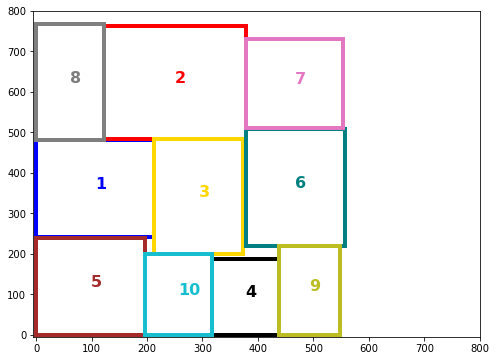

In [9]:
plt.figure(figsize=(8,6))
K=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
K=["blue", "red", "gold", "k", "brown", "teal", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i in instance.i:
    print(i,value(instance.xp[i]),value(instance.yp[i]))
    plt.plot( (value(instance.xp[i]),value(instance.xp[i]+instance.L[i])) , (value(instance.yp[i]),value(instance.yp[i])) , c=K[i-1], lw=4 )
    plt.plot( (value(instance.xp[i]),value(instance.xp[i]+instance.L[i])) , (value(instance.yp[i]+instance.W[i]),value(instance.yp[i]+instance.W[i])), c=K[i-1] , lw=4  )
    plt.plot( (value(instance.xp[i]),value(instance.xp[i])) , (value(instance.yp[i]),value(instance.yp[i]+instance.W[i])) , c=K[i-1], lw=4  )
    plt.plot( (value(instance.xp[i]+instance.L[i]),value(instance.xp[i]+instance.L[i])) , (value(instance.yp[i]),value(instance.yp[i]+instance.W[i])), c=K[i-1] , lw=4  )
    plt.text(value(instance.xp[i]+instance.L[i]/2),value(instance.yp[i]+instance.W[i]/2), s=str(i), fontweight='bold',fontsize=16,c=K[i-1] )
    
print('OF= ',value(instance.obj))
plt.xlim(-5,800)
plt.ylim(-5,800)


In [7]:
'''for w in range(20):
    plt.figure(figsize=(8,8))
    for i in instance.i:
        x=1000*random.random()
        y=1000*random.random()
        plt.plot( (x,x+value(instance.L[i]) ) , (y,y) , c=K[i-1], lw=4 )
        plt.plot( (x,x+value(instance.L[i])) , (y+value(instance.W[i]),y+value(instance.W[i]) ), c=K[i-1] , lw=4  )
        plt.plot( (x,x) , (y,y+value(instance.W[i])) , c=K[i-1], lw=4  )
        plt.plot( (x+value(instance.L[i]),x+value(instance.L[i])) , (y,y+value(instance.W[i])), c=K[i-1] , lw=4  )
        plt.text(x+value(instance.L[i]/2),y+value(instance.W[i]/2), s=str(i), fontweight='bold',fontsize=16,c=K[i-1] )
        plt.xlim(0,1300)
        plt.ylim(0,1300)
        plt.savefig('Box '+str(w)+' .png', format='png', bbox_inches='tight', dpi=500)

'''

"for w in range(20):\n    plt.figure(figsize=(8,8))\n    for i in instance.i:\n        x=1000*random.random()\n        y=1000*random.random()\n        plt.plot( (x,x+value(instance.L[i]) ) , (y,y) , c=K[i-1], lw=4 )\n        plt.plot( (x,x+value(instance.L[i])) , (y+value(instance.W[i]),y+value(instance.W[i]) ), c=K[i-1] , lw=4  )\n        plt.plot( (x,x) , (y,y+value(instance.W[i])) , c=K[i-1], lw=4  )\n        plt.plot( (x+value(instance.L[i]),x+value(instance.L[i])) , (y,y+value(instance.W[i])), c=K[i-1] , lw=4  )\n        plt.text(x+value(instance.L[i]/2),y+value(instance.W[i]/2), s=str(i), fontweight='bold',fontsize=16,c=K[i-1] )\n        plt.xlim(0,1300)\n        plt.ylim(0,1300)\n        plt.savefig('Box '+str(w)+' .png', format='png', bbox_inches='tight', dpi=500)\n\n"